In [17]:
# -*- coding: utf-8 -*-
import cv2
import os
import sys
sys.path.insert(0,"/world/data-gpu-112/liliang/pytorch-reid")
import random
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import ipdb


In [18]:
def _get_pred(model, dataloader, task_index):
    def _to_ndarray(tensor_images):
        normalize_mean = np.reshape(np.array([0.485, 0.456, 0.406]), [3, 1, 1])
        normalize_variance = np.reshape(np.array([0.229, 0.224, 0.225]), [3, 1, 1])
        np_imgs=[]
        for img in tensor_images:
            img = img.cpu()
            img = np.array(img).astype(np.float32)
            img = img * normalize_variance + normalize_mean
            img *= 255.0
            img = np.transpose(img, [1,2,0]).astype(np.float32)
            np_imgs.append(img)
        return np_imgs
    
    import torch
    gt_labels = []
    pred_labels = []
    images_lst = []
    rand_idx = random.randint(0,100)
    batch_count = 1
    num_batches = 1
    
    for idx, batch in enumerate(dataloader):
        # get data
        if idx!=rand_idx:
            continue
        images, labels = batch
        images = images.cuda(0)

        # Run forward
        with torch.no_grad():
            _, rets = model(images)
            rets = rets[task_index]
            if isinstance(rets, list):
                rets = rets[0]
            rets = rets.cpu().numpy()

        # Accumulate results
        gt_labels += labels.tolist()
        pred_labels += np.argmax(rets, axis=1).tolist()
        images_lst += _to_ndarray(images)

        if idx > 0 and idx % 500 == 0:
            logging.info("[CLASSIFICATION_EVALUATION] %s/%s batches......" %
                         (idx, num_batches))
        print(idx)
        batch_count += 1
        if batch_count > num_batches:
#             seed = random.sample(range(len(gt_labels)), 56)
#             gt_labels = np.asarray(gt_labels)[seed]
#             pred_labels = np.asarray(pred_labels)[seed]
#             images_lst = np.asarray(images_lst)[seed]
            break
    return images_lst, gt_labels, pred_labels

In [19]:
def run_eval(task_index):
    # config
    config=json.load(open(config_path,"r"))
    config["task_fc"] = [172405, 12, 2, 2, 8, 2]
    
    # load model
    from nets.model_main import mt_net
    from utils import model_utils
    model = mt_net(config, model_name=config["model_params"]["model"],
                    pcb_n_parts=config["model_params"]["pcb_n_parts"])
    model_utils.restore_model(pretrain_snapshot, model)
    model.eval()
    model.cuda(0)
    
    # base transformation
    transforms_list = []
    import torchvision.transforms as transforms
    transforms_list.append(transforms.Resize((config["img_h"], config["img_w"])))
    transforms_list.append(transforms.ToTensor())
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transforms_list.append(normalize)
    all_transforms = transforms.Compose(transforms_list)
    
    # load dataset
    from input_pipeline.lmdb_dataset import LMDBDataset
    dataset = LMDBDataset(        
                lmdb_path,
                transform=all_transforms
            )
    from torch.utils.data import DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4)
    
    # forward
    imgs, gt_labels, pred_labels = _get_pred(model, dataloader, task_index)
    
    return imgs, gt_labels, pred_labels

15
ACC:0.9821


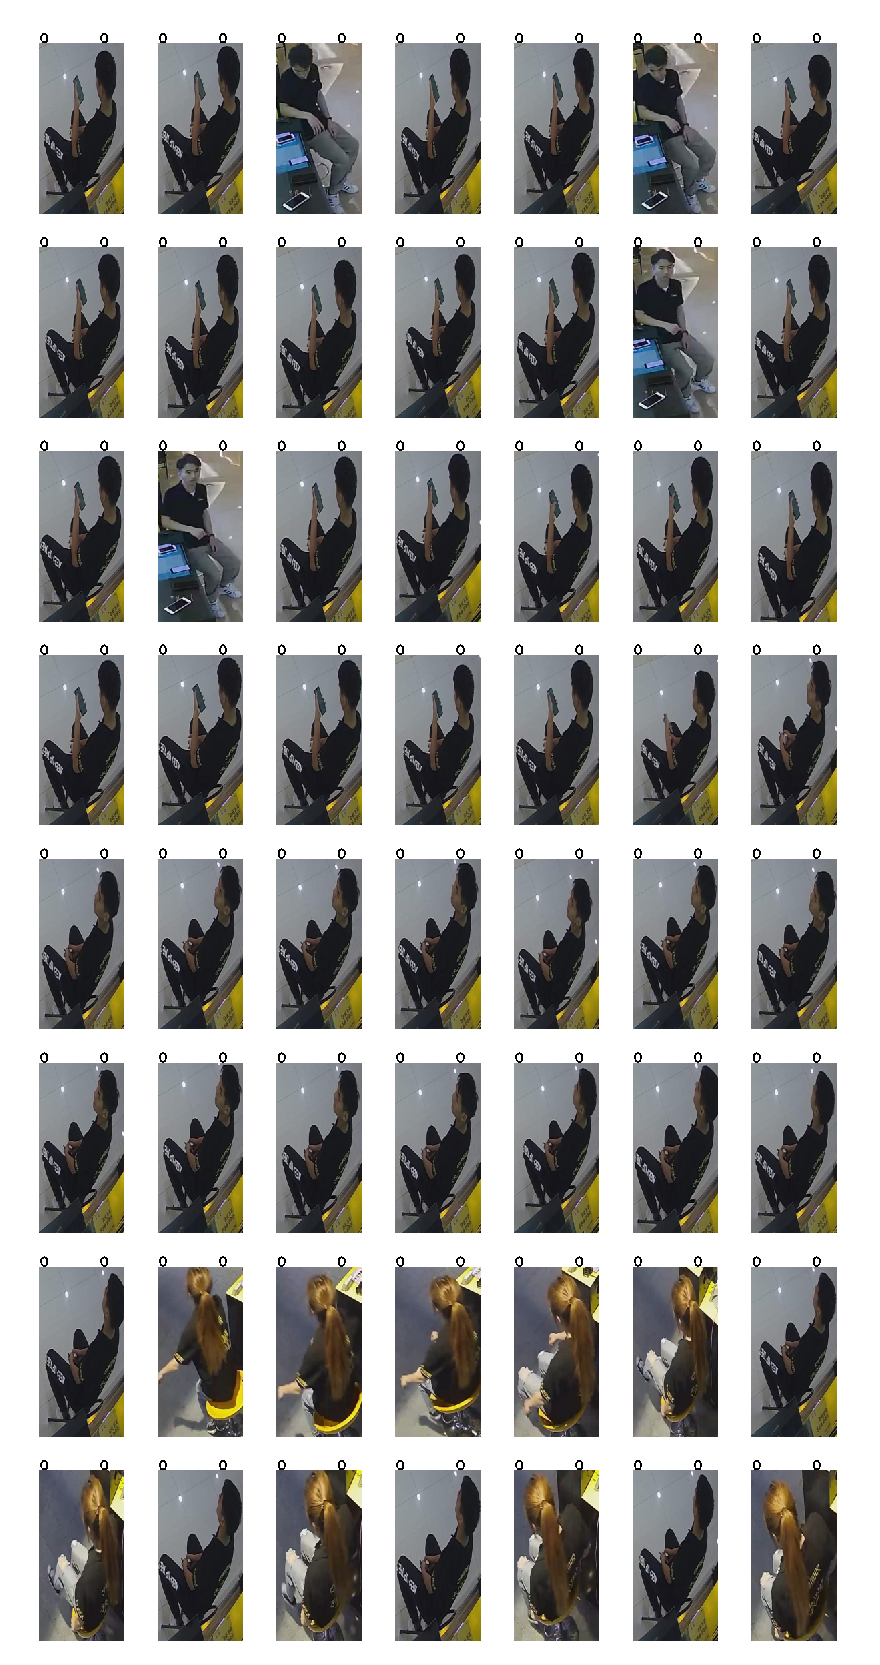

In [22]:
# plt config
h_gap = 50
v_gap = 50
text_gap = 45
rows = 8
cols = 7
num_samples = rows*cols
img_size = (256, 128)
page = np.ones(((img_size[0]+h_gap)*rows, (img_size[1]+v_gap)*cols, 3), dtype=np.uint8) * 255

pretrain_snapshot = "/world/data-gpu-112/liliang/pytorch-output-mt/v5_sitting_layer3_lr001/model_attr_best.pth"
lmdb_path = "/world/data-c26/liliang/person_attribute/v5/test/sitting"
config_path = "/world/data-gpu-112/liliang/pytorch-output-mt/v5_sitting_layer3/params_mt.json"
batch_size = num_samples
task_idx = {"age":1, "bag":2, "gender":3, "orient":4, "sitting":5}
age_scpoe_mapping = {0:"0-1", 1:"2-5", 2:"6-10", 3:"11-15", 4:"16-20", 
                    5:"21-25", 6:"25-30", 7:"31-40", 8:"41-50", 
                     9:"51-60", 10:"61-80", 11:"80+", }

# imgs to np.ndarray
imgs, gt_labels, pred_labels = run_eval(task_idx["sitting"])

k=0
for row in range(1,rows+1):
    for col in range(1,cols+1):
        gt_label = gt_labels[col*(row-1)+col-1]
        pred_label = pred_labels[col*(row-1)+col-1]
#         gt_label = age_scpoe_mapping[gt_label]
#         pred_label = age_scpoe_mapping[pred_label]
        text_color = (0,0,255) if gt_label!=pred_label else (0,0,0)
        cv2.putText(page, str(gt_label), \
                    ((col-1)*(img_size[1]+v_gap), (row-1)*(h_gap+img_size[0])+50), \
                    cv2.FONT_HERSHEY_PLAIN, 1.5, text_color, 2)
        cv2.putText(page, str(pred_label), \
                    ((col-1)*(img_size[1]+v_gap)+90, (row-1)*(h_gap+img_size[0])+50), \
                    cv2.FONT_HERSHEY_PLAIN, 1.5, text_color, 2)
        page[row*h_gap+(row-1)*img_size[0]:row*(h_gap+img_size[0])\
            , (col-1)*(v_gap+img_size[1]):col*img_size[1]+(col-1)*v_gap] \
            = imgs[k][:,:,::-1]
        k+=1

correct_count = 0
for gt, pred in zip(gt_labels, pred_labels):
    if gt == pred:
        correct_count += 1
accuracy = 1.0 * correct_count / len(gt_labels)
print("ACC:%.4f"%accuracy)

plt.figure(figsize = (30,30))
plt.axis('off')
plt.imshow(cv2.cvtColor(page, cv2.COLOR_BGR2RGB))